# ==== ***Flu Shot Learning*** ====

#### The COVID-19 pandemic
- In this time of global health crisis, the importance of vaccines cannot be overstated. However, this is a message that reaches different sectors of society with varying degrees of success. The ability to predict who is most or least likely to get a vaccine is crucial in developing a suitable public health program and in deciding where to target public service announcements. Here I will look at a dataset made available by drivendata.org for a competition, in which the results of questionnaires which ask questions about the respondents' behaviours and attitudes towards the flu virus are compared with the information on whether the respondent did or did not receive the vaccine for the H1N1 bird flu, or for the seasonal flu.

## Load modules and data

- First we load in the modules. The majority of these are different skelarn functions.

In [89]:
# Fundamental
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin, BaseEstimator

# Modelling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from catboost import CatBoostClassifier
from sklearn.svm import LinearSVC, SVC

# Testing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
from scipy.stats import pearsonr as corr

# Other
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [135]:
dfx = pd.read_csv('training_set_features.csv')
yall = pd.read_csv('training_set_labels.csv').values[:,1:] # First col = h1n1, second = seasonal.
feats = list(dfx.columns) # This gives a list of all features

# Whereas dfx is just the features, dfall combines it with labels. Useful for some plotting.
dfall = dfx.copy()
dfall['h1n1_vaccine_label'] = yall[:,0]
dfall['seas_vaccine_label'] = yall[:,1]

- The features available are as follows:

In [3]:
for f in feats:
    print(f)

respondent_id
h1n1_concern
h1n1_knowledge
behavioral_antiviral_meds
behavioral_avoidance
behavioral_face_mask
behavioral_wash_hands
behavioral_large_gatherings
behavioral_outside_home
behavioral_touch_face
doctor_recc_h1n1
doctor_recc_seasonal
chronic_med_condition
child_under_6_months
health_worker
health_insurance
opinion_h1n1_vacc_effective
opinion_h1n1_risk
opinion_h1n1_sick_from_vacc
opinion_seas_vacc_effective
opinion_seas_risk
opinion_seas_sick_from_vacc
age_group
education
race
sex
income_poverty
marital_status
rent_or_own
employment_status
hhs_geo_region
census_msa
household_adults
household_children
employment_industry
employment_occupation


- These are of the following types:

**Binary**
- behavioral_antiviral_meds - Has taken antiviral medications. 
- behavioral_avoidance - Has avoided close contact with others with flu-like symptoms. 
- behavioral_face_mask - Has bought a face mask. 
- behavioral_wash_hands - Has frequently washed hands or used hand sanitizer. 
- behavioral_large_gatherings - Has reduced time at large gatherings.
- behavioral_outside_home - Has reduced contact with people outside of own household.
- behavioral_touch_face - Has avoided touching eyes, nose, or mouth. 
- doctor_recc_h1n1 - H1N1 flu vaccine was recommended by doctor. 
- doctor_recc_seasonal - Seasonal flu vaccine was recommended by doctor.
- chronic_med_condition - Has a chronic illness from a specified list.
- child_under_6_months - Has regular close contact with a child under the age of six months.
- health_worker - Is a healthcare worker. 
- health_insurance - Has health insurance.

**Numerical (integers)**
- h1n1_concern - Rating from 0 to 3
- h1n1_knowledge - Rating from 0 to 2
- opinion_h1n1_vacc_effective - Respondent's opinion about H1N1 vaccine effectiveness. Rating from 0 to 5.
- opinion_h1n1_risk - Respondent's opinion about risk of getting sick with H1N1 flu without vaccine. Rating from 0 to 5.
- opinion_h1n1_sick_from_vacc - Respondent's worry of getting sick from taking H1N1 vaccine. Rating from 0 to 5.
- opinion_seas_vacc_effective - Respondent's opinion about seasonal flu vaccine effectiveness. Rating from 0 to 5.
- opinion_seas_risk - Respondent's opinion about risk of getting sick with seasonal flu without vaccine. Rating from 0 to 5.
- opinion_seas_sick_from_vacc - Respondent's worry of getting sick from taking seasonal flu vaccine. Rating from 0 to 5.
- household_adults - Number of other adults in household, maxed out at 3.
- household_children - Number of children in household, maxed out at 3.

**Categorical**
- age_group - Age group of respondent.
- education - Self-reported education level.
- race - Race of respondent.
- sex - Sex of respondent.
- income_poverty - Household annual income of respondent with respect to 2008 Census poverty thresholds.
- marital_status - Marital status of respondent.
- rent_or_own - Housing situation of respondent.
- employment_status - Employment status of respondent.
- hhs_geo_region - Respondent's residence using a 10-region geographic classification. Values are represented as short random character strings.
- census_msa - Respondent's residence within metropolitan statistical areas (MSA) as defined by the U.S. Census.
- employment_industry - Type of industry respondent is employed in. Values are represented as short random character strings.
- employment_occupation - Type of occupation of respondent. Values are represented as short random character strings.

In [4]:
dfx.head()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,...,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,...,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,...,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb


## Initial (unfitted) preprocessing

- Initially age group is a categorical variable, saved as a string. Here we create a numerical variable at the midpoint of each category.

In [5]:
dfx['age_group'].unique()

array(['55 - 64 Years', '35 - 44 Years', '18 - 34 Years', '65+ Years',
       '45 - 54 Years'], dtype=object)

In [6]:
def initial_processing(df):
    df['age_num'] = 0
    df.loc[df['age_group'] == '18 - 34 Years','age_num'] = (34-18)/2
    df.loc[df['age_group'] == '35 - 44 Years','age_num'] = (44-35)/2
    df.loc[df['age_group'] == '45 - 54 Years','age_num'] = (54-45)/2
    df.loc[df['age_group'] == '55 - 64 Years','age_num'] = (64-55)/2
    df.loc[df['age_group'] == '65+ Years','age_num']     = 70
    if 'respondent_id' in df.columns:
        df.drop(columns=['respondent_id'],inplace=True)

In [7]:
initial_processing(dfx)

## Data exploration

### *Opinion distributions*

- It's always useful to see the distribution of our variables. Below we see the pdf of the different "opinion" variables. We can see that this gives us an **idea**.

- As we might expect, opinion polls are highly weighted at the ends. However, I find it reasonable to assume that someone who puts 1 or 5 would, on average, feel much more strongly than someone who puts 2 or 4. This is because the rating system is bounded, so someone who would put, for example, 10, is still limited to 5. I will use this later on to give a non-linear weighting to the columns.

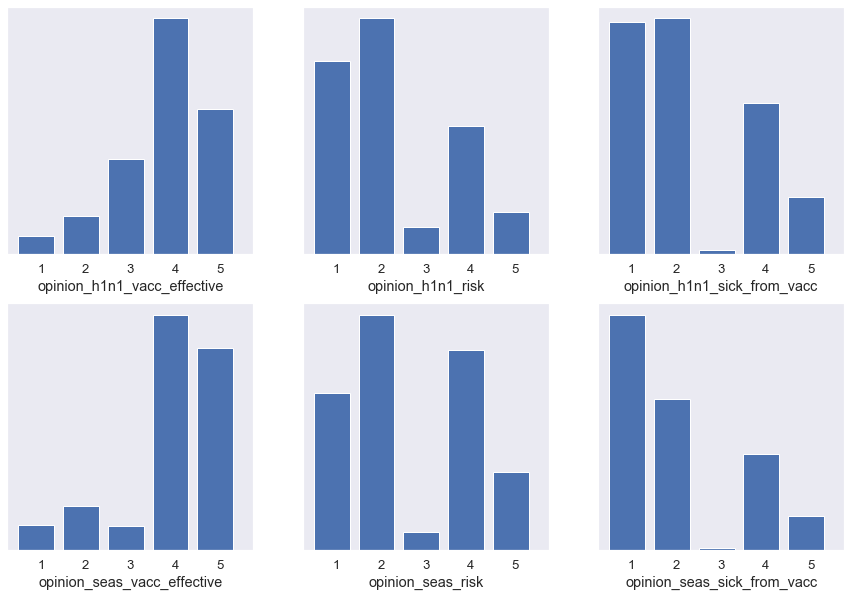

In [269]:
sns.set(font_scale=1.2)
fig, axes = plt.subplots(figsize = (15, 10), ncols=3, nrows=2)
axeslist = [axes[0,i] for i in range(3)] + [axes[1,i] for i in range(3)]
i=0
for thing in feats:
    if 'opinion' in thing:
        dfx[thing].hist(ax = axeslist[i], bins=[0.5,1.5,2.5,3.5,4.5,5.5], grid=False, width=0.8)
        axeslist[i].set_xlabel(thing)
        axeslist[i].set_yticks([])
        i+=1
plt.show()

### *Effect of binary variables*

- Here I take a quick look at the various binary variables in the dataset. I think this is quite a nice way of combining a few different pieces of information into one. In the dashed boxes (with the scale on the right) is the total number of people who answered 'yes' for a given binary variable. In the blue and orange boxes, with scale on the left, is the relative increase in likelihood of a person who answered yes to that variable getting the H1N1 or seasonal vaccines.

In [208]:
binvars = ['behavioral_antiviral_meds','behavioral_avoidance','behavioral_face_mask','behavioral_wash_hands',
           'behavioral_large_gatherings','behavioral_outside_home','behavioral_touch_face','doctor_recc_h1n1',
           'doctor_recc_seasonal','chronic_med_condition','child_under_6_months','health_worker','health_insurance']
opinioncols = [col for col in dfx.columns if 'opinion' in col]

In [229]:
binvardata_h1n1 = []
binvardata_seas = []
totals = []

h1n1_overall_fraction = dfall['h1n1_vaccine_label'].sum()/len(dfall)
seas_overall_fraction = dfall['seas_vaccine_label'].sum()/len(dfall)

for bv in binvars:
    dfbinvar = dfall[dfall[bv]==1]
    dfbinvar_h1n1_number = dfbinvar['h1n1_vaccine_label'].sum()
    dfbinvar_seas_number = dfbinvar['seas_vaccine_label'].sum()
    dfbinvar_total = len(dfbinvar)
    
    h1n1_binvar_fraction = dfbinvar_h1n1_number / dfbinvar_total
    seas_binvar_fraction = dfbinvar_seas_number / dfbinvar_total
    
    h1n1_increase = (h1n1_binvar_fraction - h1n1_overall_fraction)/h1n1_overall_fraction
    seas_increase = (seas_binvar_fraction - seas_overall_fraction)/seas_overall_fraction
    
    binvardata_h1n1.append(h1n1_increase * 100) # times 100 to make into a percentage
    binvardata_seas.append(seas_increase * 100)
    totals.append(dfbinvar_total)

In [236]:
increase_list = binvardata_h1n1 + binvardata_seas
virus_list = ['H1N1']*len(binvardata_h1n1) + ['Seasonal']*len(binvardata_seas)
df_for_plotting_binvars = pd.DataFrame({
    'Binary Variable': binvars + binvars,
    'Increase':increase_list,
    'Virus':virus_list
})

In [256]:
translated_binvars = [
    '...is on antivirals',
    '...is avoiding close contact\nwith others',
    '...wears a face mask',
    '...washes their hands',
    '...avoids large gatherings',
    '...avoids going out of the house',
    '...avoids touching their face',
    '...has been recommended the\nH1N1 vaccine by a doc',
    '...has been recommended the\nseasonal vaccine by a doc',
    '...has a chronic medical condition',
    '...has a child under 6 months old',
    '...is a health worker',
    '...has health insurance'
]

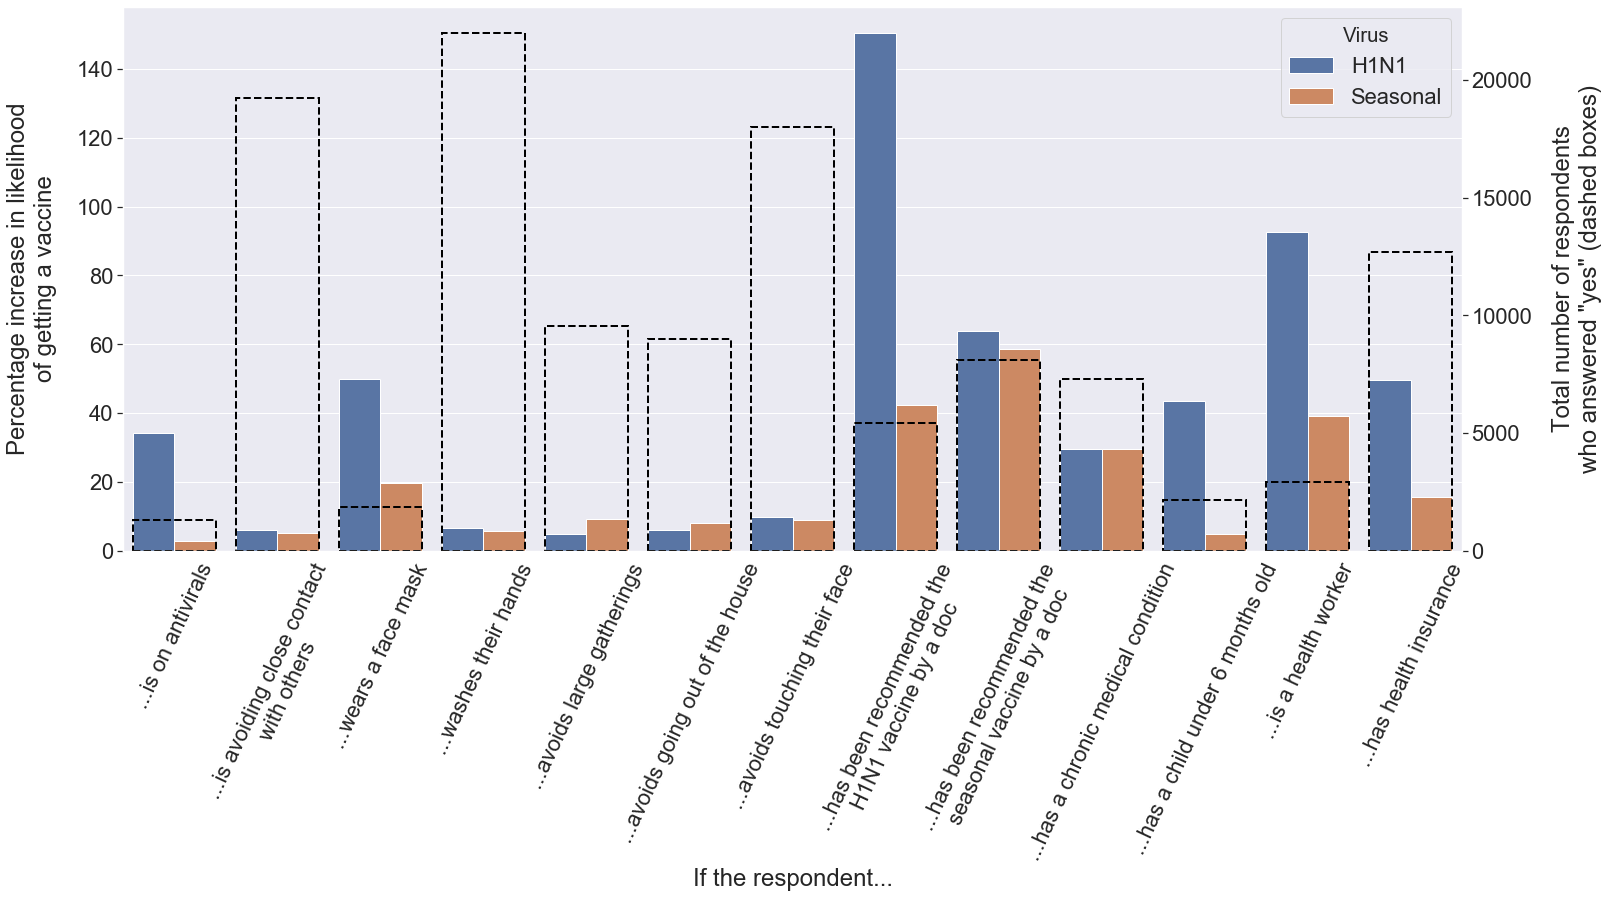

In [271]:
sns.set(font_scale=2)
dftemp = pd.DataFrame({'Binary Variable': binvars, 'Total':totals})
f, ax1 = plt.subplots(figsize=(24,10))
plt.xticks(rotation=65);
ax2 = ax1.twinx()
ax2.grid()
sns.barplot(x='Binary Variable', y='Increase', hue='Virus', data=df_for_plotting_binvars, ax=ax1)
sns.barplot(x='Binary Variable', y='Total', data=dftemp, ax=ax2, fill=False, edgecolor=(0,0,0), linewidth=2, linestyle='--')
ax1.set_ylabel('Percentage increase in likelihood\nof getting a vaccine', labelpad=20)
ax2.set_ylabel('Total number of respondents\nwho answered "yes" (dashed boxes)', labelpad=20)
ax1.set_xlabel('If the respondent...');
ax1.set_xticklabels(translated_binvars);
plt.savefig('flu_behaviour_02.png',bbox_inches='tight')

### *Correlation matrix*

- Of course, these behaviours are not independent. It's worth looking at the correlation between various opinions and behaviours. If the correlation strength is over 0.2 I've labelled it on the matrix. 

- It is interesting, how few variables show significant correlation, even when we look at all with correlation strengths of 0.1 or over. In particuar, being a health worker does not correlate strongly with any change in behaviour.

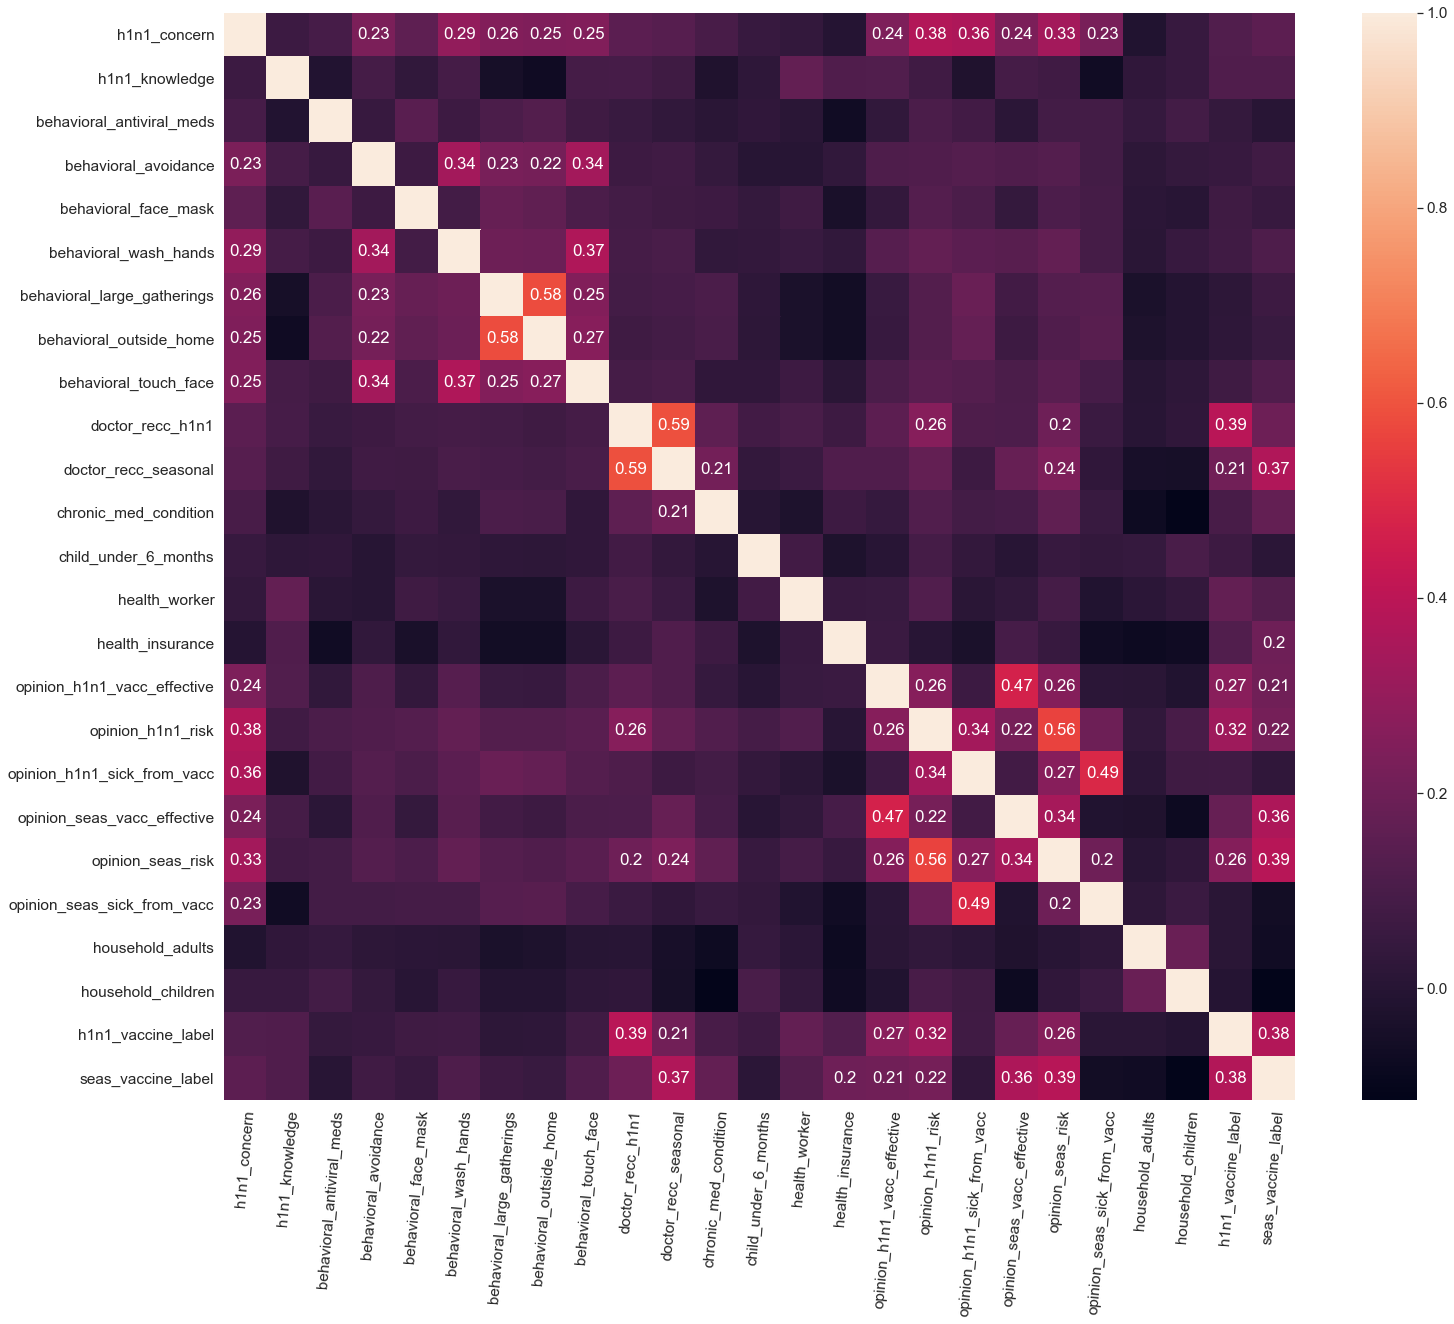

In [276]:
corrmat = dfall.drop(columns=['respondent_id']).corr()
sns.set(font_scale=1.4)
corrlabels = corrmat.values.tolist()
for i,row in enumerate(corrlabels):
    for j,val in enumerate(row):
        if val==1 or np.abs(val)<0.2:
            corrlabels[i][j] = ''
        else:
            corrlabels[i][j] = str(round(val,2))
corrlabels = np.array(corrlabels)

f =plt.figure(figsize=(24,20))
sns.heatmap(corrmat, annot=corrlabels, fmt='')

# Below is a workaround to get the heatmap to display properly
b, t = plt.ylim()
plt.ylim(b+0.5, t-0.5)
plt.xticks(rotation=85)
plt.show()

## Create objects for fitted preprocessing

- Ok, now we want to start modelling to predict the labels. We create lists of numerical and categorical columns. We will use sklearns "pipelines" for easy and reproducible fitted transformations.

In [21]:
num_cols = list(dfx.columns[dfx.dtypes != object])
cat_cols = list(dfx.columns[dfx.dtypes == object])

### *Existing transformers*
Here we make pipes using built-in transformers.

In [22]:
numerical_processing = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('mmscal', MinMaxScaler())
])

categorical_processing = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

### *Custom transformers / pipelines*

- We want a custom pipeline to apply a non-linear weighting to the opinion scores.

In [277]:
class WeightedOpinions(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for col in X.columns:
            if 'opinion' in col:
                X[col] = (X[col]-3)**3 # 3 is the mid-point. Raise to an odd-power to preserve monotonicity.
            if 'concern' in col:
                X[col] = (X[col]-1.5)**3
        return X
    
extra_processing = Pipeline([
    ('wo', WeightedOpinions()),
    ('imputer', SimpleImputer(strategy='median')),
    ('mmscal', MinMaxScaler())
])

### *Combine into ColumnTransformer*

In [278]:
preprocessor_weighted = ColumnTransformer(
    transformers = [
    ('ext', extra_processing, num_cols),
    ('num', numerical_processing, num_cols),
    ('cat', categorical_processing, cat_cols)
    ], 
    remainder='drop')

preprocessor_linear = ColumnTransformer(
    transformers = [
    ('num', numerical_processing, num_cols),
    ('cat', categorical_processing, cat_cols)
    ], 
    remainder='drop')

## Define models

- We'll try a whole host of different models.

In [279]:
global_max_iter = 600

model_logreg_l1 = MultiOutputClassifier(
    estimator=LogisticRegression(penalty='l1', C=1, solver='liblinear', max_iter=global_max_iter)
)

model_logreg_l2 = MultiOutputClassifier(
    estimator=LogisticRegression(penalty='l2', C=1, solver='lbfgs', max_iter=global_max_iter)
)

model_logreg_elastic = MultiOutputClassifier(
    estimator=LogisticRegression(penalty='elasticnet', C=1, solver='saga', max_iter=global_max_iter, l1_ratio = 0.5)
)

model_rf = MultiOutputClassifier(
    estimator=RandomForestClassifier(max_depth=10)
)

model_cat = MultiOutputClassifier(
    estimator=CatBoostClassifier()
)

model_svc = MultiOutputClassifier(
    estimator=SVC(probability=True)
)

In [76]:
dict_of_models = {
    'logred_l1':model_logreg_l1,
    'logred_l2':model_logreg_l2,
    'logreg_elastic':model_logreg_elastic,
    'rf':model_rf,
    'cat':model_cat,
    'svc':model_svc,
}

## Define output translation functions

In [77]:
def transform_MOC_output(arrin):
    h1n1_probs = arrin[0][:,1]
    seas_probs = arrin[1][:,1]
    return np.stack([h1n1_probs, seas_probs]).T

## Create train/test split

In [78]:
dfxtr, dfxcv, ytr, ycv = train_test_split(
    dfx,
    yall,
    test_size=0.33,
    shuffle=True,
    stratify=yall,
    random_state=6
)

## Fit and test models

### *Process*

In [79]:
models_to_test = dict_of_models.keys() # Can change to a subset

In [80]:
def fit_all(which_models):
    for modelname in which_models:
        model = dict_of_models[modelname]
        model.fit(xtr, ytr);
        print('Model {} fit complete'.format(modelname))
    return

def test_all(which_models, verbose=1):
    dict_of_ypr = {}
    dict_of_auc = {}
    for modelname in which_models:
        model = dict_of_models[modelname]
        ypr = transform_MOC_output(model.predict_proba(xcv))
        dict_of_ypr[modelname] = ypr
        dict_of_auc[modelname] = roc_auc_score(ycv, ypr)
        print('Model {} test complete'.format(modelname))
    if verbose:
        print()
        for m in sorted(dict_of_auc, key=lambda mm: dict_of_auc[mm])[::-1]:
            print('{:4.4f}  --  {}'.format(dict_of_auc[m], m))
    return dict_of_auc, dict_of_ypr

### *Linear opinion ratings*

In [81]:
xtr = preprocessor_linear.fit_transform(dfxtr)
xcv = preprocessor_linear.transform(dfxcv)

#### Fit

In [ ]:
fit_all(models_to_test)

#### Test

In [96]:
test_all(models_to_test);

Model logred_l1 test complete
Model logred_l2 test complete
Model logreg_elastic test complete
Model rf test complete
Model cat test complete
Model svc test complete

0.8448  --  logred_l1
0.8447  --  logreg_elastic
0.8446  --  logred_l2
0.8432  --  svc
0.8427  --  cat
0.8295  --  rf


### *Non-linear opinion ratings*

In [82]:
xtr = preprocessor_weighted.fit_transform(dfxtr)
xcv = preprocessor_weighted.transform(dfxcv)

In [97]:
fit_all(models_to_test)

Model logred_l1 fit complete
Model logred_l2 fit complete
Model logreg_elastic fit complete
Model rf fit complete
Learning rate set to 0.035304
0:	learn: 0.6658288	total: 114ms	remaining: 1m 54s
1:	learn: 0.6415127	total: 188ms	remaining: 1m 33s
2:	learn: 0.6193654	total: 264ms	remaining: 1m 27s
3:	learn: 0.5983579	total: 339ms	remaining: 1m 24s
4:	learn: 0.5797849	total: 421ms	remaining: 1m 23s
5:	learn: 0.5626626	total: 492ms	remaining: 1m 21s
6:	learn: 0.5475796	total: 757ms	remaining: 1m 47s
7:	learn: 0.5327910	total: 863ms	remaining: 1m 47s
8:	learn: 0.5196621	total: 960ms	remaining: 1m 45s
9:	learn: 0.5084771	total: 1.06s	remaining: 1m 44s
10:	learn: 0.4989344	total: 1.08s	remaining: 1m 36s
11:	learn: 0.4887738	total: 1.35s	remaining: 1m 51s
12:	learn: 0.4784512	total: 1.57s	remaining: 1m 59s
13:	learn: 0.4698468	total: 1.7s	remaining: 1m 59s
14:	learn: 0.4613215	total: 1.86s	remaining: 2m 2s
15:	learn: 0.4538633	total: 1.95s	remaining: 2m
16:	learn: 0.4489948	total: 1.96s	remain

In [99]:
test_all(models_to_test);

Model logred_l1 test complete
Model logred_l2 test complete
Model logreg_elastic test complete
Model rf test complete
Model cat test complete
Model svc test complete

0.8458  --  logred_l1
0.8458  --  logreg_elastic
0.8457  --  logred_l2
0.8450  --  svc
0.8413  --  cat
0.8328  --  rf


### *Results*

- Ok, so it seems that the non-linear opinion weighting has a *very* slight increase in AUC.

- Notably though, all models did basically just as good as each other. However, we won't bother with a neural net. It seems clear that a simple approach does just as well as a complex one here, and explainability is key in healthcare.

### *Plot ROC*

In [18]:
def plot_roc(dict_of_ypr, label):
    def subroutine(y_true, y_score, label_name, ax):
        fpr, tpr, thresholds = roc_curve(y_true, y_score)
        ax.plot(fpr, tpr)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_ylabel('TPR')
        ax.set_xlabel('FPR')
        ax.set_title(
            f"{label_name}: AUC = {roc_auc_score(y_true, y_score):.4f}"
        )

    fig, ax = plt.subplots(1, 2, figsize=(7, 3.5))
    ypr = dict_of_ypr[label]
    
    subroutine(
        ycv[:,0], 
        ypr[:,0], 
        'h1n1_vaccine',
        ax=ax[0]
    )
    subroutine(
        ycv[:,1], 
        ypr[:,1], 
        'seasonal_vaccine',
        ax=ax[1]
    )
    fig.tight_layout()
    return None

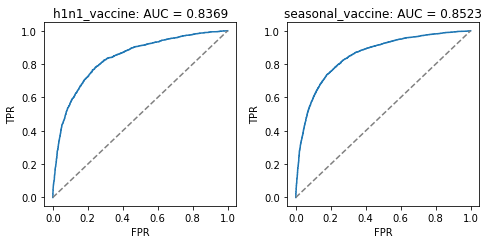

In [206]:
plot_roc(dict_of_ypr,'logred_l2')

### *Confusion matrix*

- Always useful to look at this to compare type-I and type-II errors.

In [117]:
ypr = np.round(dict_of_ypr['logred_l1'])
confmat_h = confusion_matrix(ycv[:,0],ypr[:,0])
confmat_s = confusion_matrix(ycv[:,1],ypr[:,1])

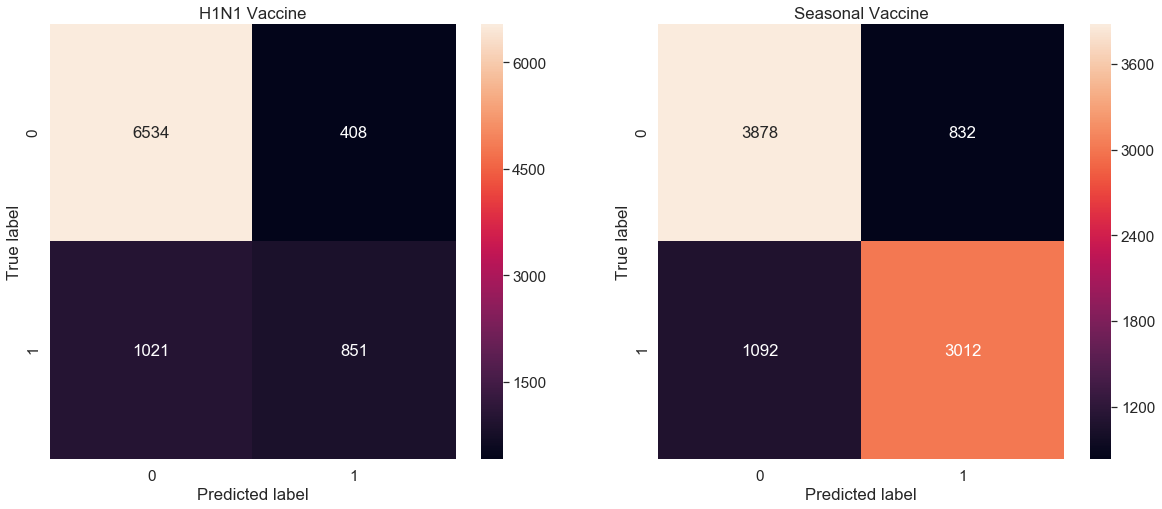

In [127]:
f, (ax1,ax2) = plt.subplots(ncols=2, figsize=(20,8))
sns.set(font_scale=1.4)
sns.heatmap(confmat_h,annot=True,fmt='g',ax=ax1)
sns.heatmap(confmat_s,annot=True,fmt='g',ax=ax2)
b, t = plt.ylim()
ax1.set_ylim(b+0.5, t-0.5)
ax2.set_ylim(b+0.5, t-0.5)
ax1.set_title('H1N1 Vaccine')
ax2.set_title('Seasonal Vaccine')
for ax in (ax1,ax2):
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')

## Optimisation

- Looks like a standard logistic regression with L1 regularisation works best. Here we'll optimise the reg strength, C.

In [41]:
def test_param_range(paramname, min_, max_=None, skip=1, logplot=0, **kwargs):
    
    if type(min_) != type([0]) and type(min_) != type(np.array([0])):
        pvalset = np.arange(min_, max_+1, skip)
    else:
        pvalset = min_
    
    if paramname in kwargs.keys():
        print('Looping parameter already in kwargs!')
        return
    
    auclist_tr = []
    auclist_cv = []

    for pval in pvalset:
        kwargs.update({paramname: pval})
        model = MultiOutputClassifier(estimator=LogisticRegression(**kwargs))
        model.fit(xtr, ytr);

        ytr_pr = transform_MOC_output(model.predict_proba(xtr))
        ycv_pr = transform_MOC_output(model.predict_proba(xcv))

        auclist_tr.append(roc_auc_score(ytr, ytr_pr))
        auclist_cv.append(roc_auc_score(ycv, ycv_pr))
    
    plt.plot(pvalset, auclist_tr, label='Training')
    plt.plot(pvalset, auclist_cv, label='Cross-val')
    plt.legend()
    plt.xlabel(paramname)
    plt.ylabel('AUC')
    if logplot:
        plt.xscale('log')
    plt.show()
    return [auclist_tr,auclist_cv]

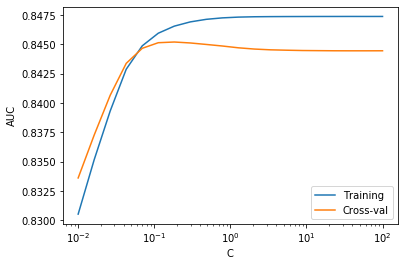

In [43]:
Cset = np.logspace(-2, 2, 20)
test_param_range('C', Cset, logplot=1, penalty='l1', solver='liblinear', max_iter=global_max_iter)

## Produce labels for submission

In [83]:
model = MultiOutputClassifier(estimator=LogisticRegression(C=0.1, penalty='l1', solver='liblinear', max_iter=global_max_iter))
model.fit(xtr,ytr)

MultiOutputClassifier(estimator=LogisticRegression(C=0.1, class_weight=None,
                                                   dual=False,
                                                   fit_intercept=True,
                                                   intercept_scaling=1,
                                                   l1_ratio=None, max_iter=600,
                                                   multi_class='warn',
                                                   n_jobs=None, penalty='l1',
                                                   random_state=None,
                                                   solver='liblinear',
                                                   tol=0.0001, verbose=0,
                                                   warm_start=False),
                      n_jobs=None)

In [84]:
df_test = pd.read_csv('test_set_features.csv')
sub_format = pd.read_csv('submission_format.csv',index_col='respondent_id')

In [85]:
initial_processing(df_test)
xte = preprocessor_weighted.transform(df_test)
ytepr = transform_MOC_output(model.predict_proba(xte))

In [86]:
sub_format['h1n1_vaccine'] = ytepr[:,0]
sub_format['seasonal_vaccine'] = ytepr[:,1]

In [88]:
sub_format.to_csv('___flu_sub_110520_01.csv', index=True)

## All done!